# Reinforcement Learning Chess

### Monte Carlo tree search (MCTS)
The aim of this notebook is to build a chess AI that can plan moves and defeat a simple opponent in a regular game of chess. My approach can be summarized as follows:
- Instead of Q-learning (learning action values) I use "V-learning" (learning state-values).
    - An advantage is that the Neural Network can learn with fewer parameters since it doesn't need to learn a seperate value for each action. In my Q-learning and Policy Gradient notebook, the output vector has a size > 4000. Now the size is only 1.
- The V-network is updated using Temporal Difference (TD) Learning, like explained in Notebook 1. 
    - This option is the simplest to code.  Other options are TD-lambda and Monte Carlo Learning.
- The Architecture of the V-network is quite arbitrary and can probably be optimized. I used a combination of small and large convolutions, combined with convolutions that range a full file or rank (1-by-8 or 8-by-1).
- Moves are planned using Monte Carlo Tree Search. This involves simulating playouts. 
    - Monte Carlo Tree Search greatly improves performance on games like chess and go because it helps the agent to plan ahead.
- These playouts are truncated after N steps and bootstrapped. 
    - This reduces the variance of the simulation outcomes and gives performance gains, since the simulation doesn't require a full playout. 
- For this version, the opponent of the RL-agent is a myopic player, that always chooses the move that results in the most material on the board or a checkmate.

**Import**

In [1]:
# !pip install chess

     |████████████████████████████████| 141 kB 427 kB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2
# !pip install --upgrade git+https://github.com/arjangroen/RLC.git@maintain-tree  # RLC is the Reinforcement Learning package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os
import inspect
import matplotlib.pyplot as plt

In [2]:
from keras.models import load_model

Using TensorFlow backend.
C:\Users\there\Anaconda3\envs\neuro140\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\there\Anaconda3\envs\neuro140\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\there\Anaconda3\envs\neuro140\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\there\Anaconda3\envs\neuro140

In [3]:
from RLC.real_chess import agent, environment, learn, tree
from endgame_environment import Board
import chess
from chess.pgn import Game

# these are FENS, which are a concise way of representing the board states
# 10 common end games were selected for training purposes
endgame_fens = [
    # King, queen, and three pawns vs king, queen, and three pawns
    "4k3/1p2pp2/8/8/8/8/1P2PP2/4K3 w - - 0 1",
    # King, rook, knight, bishop, and pawn vs king, rook, knight, bishop, and pawn
    "4k3/1prnbp2/8/8/8/8/1PRNBP2/4K3 w - - 0 1",
    # King, two bishops and three pawns vs king, two knights and three pawns
    "4k3/1p1bpp2/8/8/8/8/1P1NNP2/4K3 w - - 0 1",
    # King, two rooks and three pawns vs king, two rooks and three pawns
    "4k3/1p1rrp2/8/8/8/8/1P1RRP2/4K3 w - - 0 1",
    # King, queen, knight, bishop and pawn vs king, queen, knight, bishop and pawn
    "4k3/1pqnbP2/8/8/8/8/1PQNBp2/4K3 w - - 0 1",
    # King, queen, two bishops and pawn vs king, queen, two bishops and pawn
    "4k3/1pqbbP2/8/8/8/8/1PQBBp2/4K3 w - - 0 1",
    # King, queen, two knights and pawn vs king, queen, two knights and pawn
    "4k3/1pqnNP2/8/8/8/8/1PQnnp2/4K3 w - - 0 1",
    # King, queen, rook, bishop, and pawn vs king, queen, rook, bishop, and pawn
    "4k3/1pqrBP2/8/8/8/8/1PQRbp2/4K3 w - - 0 1",
    # King, queen, rook, knight, and pawn vs king, queen, rook, knight, and pawn
    "4k3/1pqrNP2/8/8/8/8/1PQRnp2/4K3 w - - 0 1",
    # King, rook, two knights and pawn vs king, rook, two knights and pawn
    "4k3/1prnNP2/8/8/8/8/1PRNnp2/4K3 w - - 0 1"
]

opponent = agent.GreedyAgent()
env = Board(opponent, FEN=None, endgame_fens=endgame_fens)
player = agent.Agent(lr=0.0005,network='big')
learner = learn.TD_search(env, player,gamma=0.9,search_time=0.9)
node = tree.Node(learner.env.board, gamma=learner.gamma)
player.model.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state (InputLayer)              (None, 8, 8, 8)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 4)      36          state[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 8)      264         state[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3, 3, 12)     876         state[0][0]                      
__________________________________________________________________________________________________
conv2d

### Launching the network

In [4]:
n_iters = 10000  # maximum number of iterations
timelimit = 3600 # maximum time for learning
network_replacement_interval = 10  # For the stability of the nearal network updates, the network is not continuously replaced



iter 0
game ended with result -1.0 and material balance -11.0 in 10 halfmoves
game ended with result 0.0 and material balance -10.0 in 81 halfmoves
game ended with result -1.0 and material balance -21.0 in 8 halfmoves
game ended with result 0.0 and material balance -15.0 in 20 halfmoves
game ended with result -1.0 and material balance -16.0 in 20 halfmoves
game ended with result -1.0 and material balance -13.0 in 8 halfmoves
game ended with result 0.0 and material balance -15.0 in 81 halfmoves
game ended with result -1.0 and material balance -16.0 in 26 halfmoves
game ended with result -1.0 and material balance -6.0 in 16 halfmoves
game ended with result -1.0 and material balance -21.0 in 10 halfmoves
iter 10
game ended with result 0.0 and material balance -4.0 in 81 halfmoves
game ended with result 0.0 and material balance -14.0 in 81 halfmoves
game ended with result -1.0 and material balance -9.0 in 64 halfmoves
game ended with result -1.0 and material balance -18.0 in 10 halfmoves

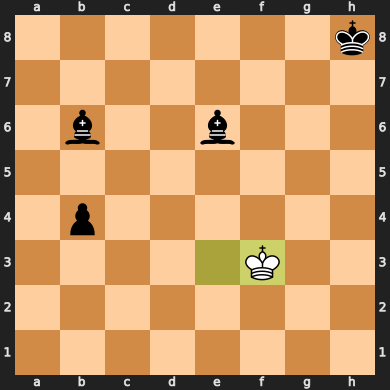

In [5]:
learner.learn(iters=n_iters,timelimit_seconds=timelimit,c=network_replacement_interval) 

### Learning performance 

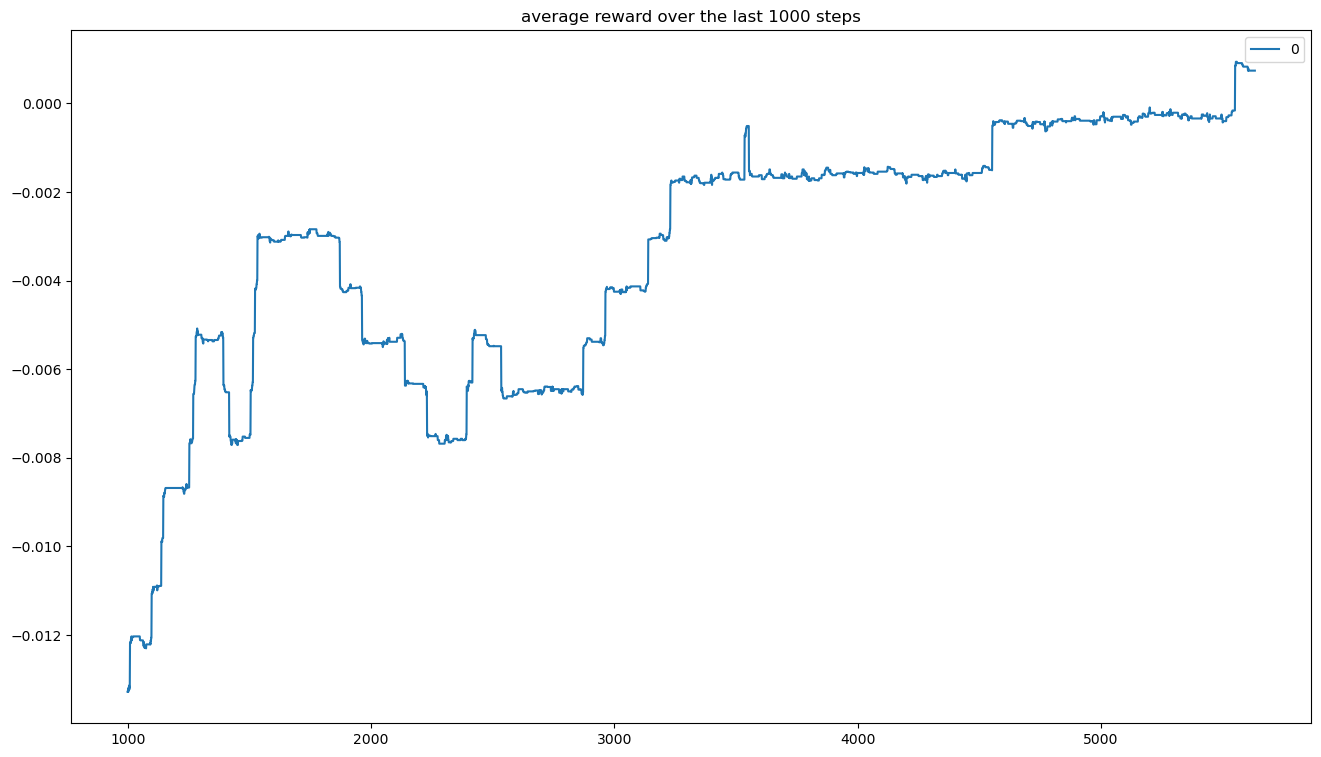

In [6]:
reward_smooth = pd.DataFrame(learner.reward_trace)
reward_smooth.rolling(window=1000,min_periods=1000).mean().plot(figsize=(16,9),title='average reward over the last 1000 steps')
plt.show()

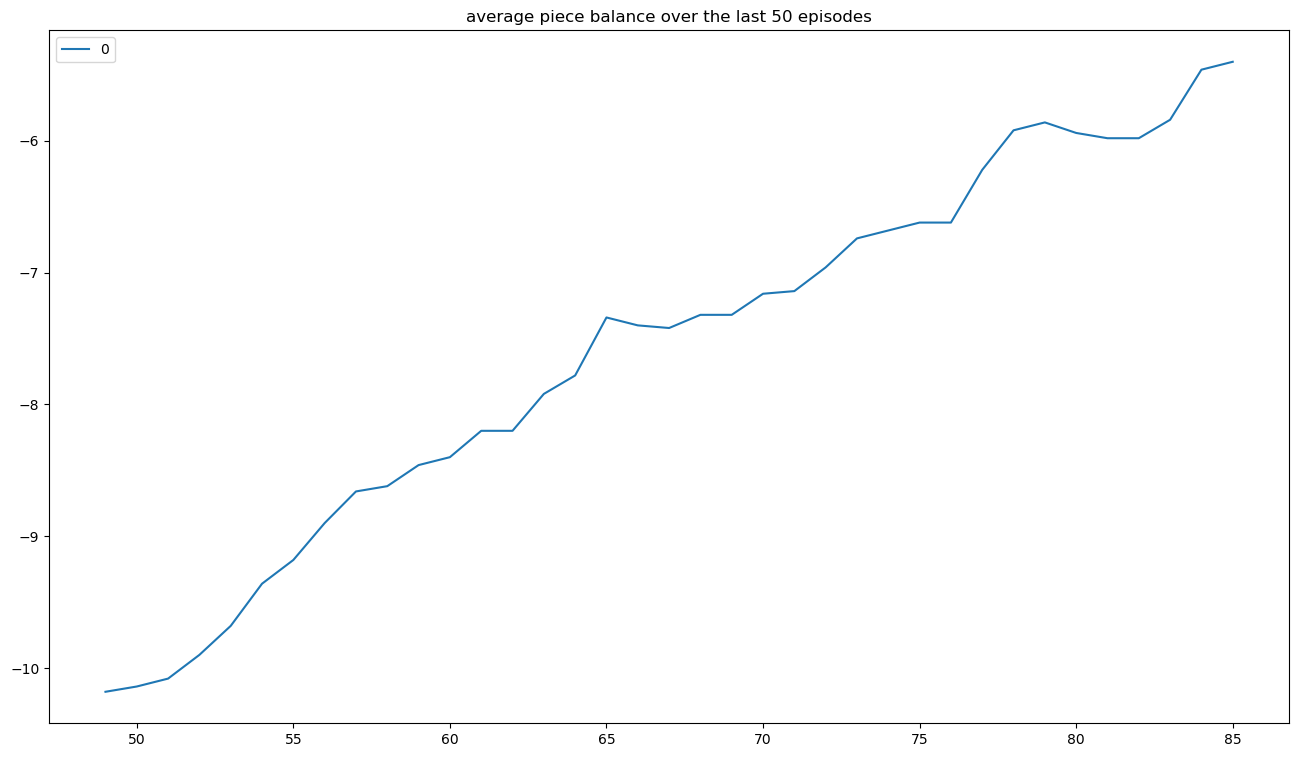

In [7]:
reward_smooth = pd.DataFrame(learner.piece_balance_trace)
reward_smooth.rolling(window=50,min_periods=50).mean().plot(figsize=(16,9),title='average piece balance over the last 50 episodes')
plt.show()

In [8]:
learner.agent.model.save('RLC_model_copy.h5')

### Final performance with large searchtime and more greedy behavior

In [9]:
learner.env.reset()
learner.search_time = 100
learner.temperature = 1/3

game ended with result 0.0 and material balance 0.0 in 101 halfmoves


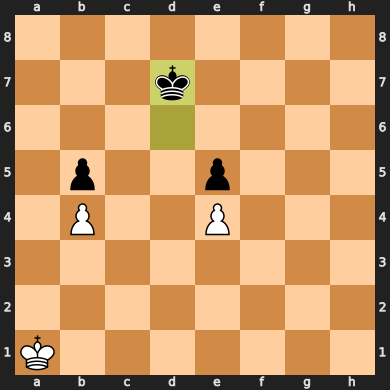

In [15]:
learner.play_game(1, maxiter=100)

In [16]:
pgn = Game.from_board(learner.env.board)
with open("rlc_pgn_copy_2","w") as log:
    log.write(str(pgn))

In [14]:
learner.agent.model.save('RLC_model_copy2.h5')

In [17]:
learner.env.reset()
learner.search_time = 100
learner.temperature = 1/3

In [18]:
learner.env.FEN

'4k3/1pqrNP2/8/8/8/8/1PQRnp2/4K3 w - - 0 1'

game ended with result 0.0 and material balance -9.0 in 101 halfmoves


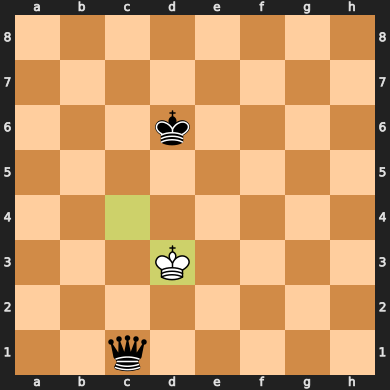

In [19]:
learner.play_game(1, maxiter=100)

In [20]:
pgn = Game.from_board(learner.env.board)
with open("rlc_pgn_copy_3","w") as log:
    log.write(str(pgn))

In [21]:
learner.agent.model.save('RLC_model_copy3.h5')